In [1]:
from itertools import product
from math import comb
import numpy as np

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from tequila import quantumchemistry
from tqdm import tqdm

from Week3_VQE.utility import obtain_potential_manual, get_molecular_data
import matplotlib.pyplot as plt

## Question 2.
Q) Optional: There is another division between classical methods, it is based on so-called separability or
size-consistency. Simply speaking, if one investigates two molecular fragments (A and B) at a large distance
from each other ($ ∼ 100 Å $) then the total electronic energy should be equal to the sum $E_{A+B} = E_A + E_B$,
where the energy of each fragment ($E_A$ or $E_B$) can be obtained in a
calculation that does not involve the other fragment. If this condition is satisfied for a particular
method, this method is separable or size-consistent. Check separability of HF, CISD, and CCSD
by taking 2 H2 fragments at a large distance from each other and comparing the total energy with
2 energies of one H2 molecule. Explain your results.

A)

In [2]:
eq_bond = 0.741
len_sep = 100
two_H2 = [['H', [0, 0, 0]],
          ['H', [0, 0, eq_bond]],
          ['H', [0, 0, len_sep]],
          ['H', [0, 0, len_sep + eq_bond]]]
single_H2 = [['H', [0, 0, 0]],
             ['H', [0, 0, eq_bond]]]
r = dict()
basis = 'sto-3g'
for m in ['HF', 'CISD', 'CCSD']:
    E_AB = obtain_potential_manual(mol_geometry=two_H2, basis=basis, method=m)
    E_A = obtain_potential_manual(mol_geometry=single_H2, basis=basis, method=m)
    r.update({m: (E_AB, 2 * E_A)})

converged SCF energy = -2.23341227446976
converged SCF energy = -2.23341227446976
converged SCF energy = -1.1167061372361
converged SCF energy = -1.11670613723611


Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.hf.RHF'>


converged SCF energy = -2.23341227446976
converged SCF energy = -2.23341227446976
E(RCISD) = -2.274038702335172  E_corr = -0.04062642786541145
converged SCF energy = -1.1167061372361
converged SCF energy = -1.11670613723611
E(RCISD) = -1.137274405529439  E_corr = -0.02056826829333389
converged SCF energy = -2.23341227446976
E(CCSD) = -2.274549066174261  E_corr = -0.04113679170449999
converged SCF energy = -1.1167061372361
E(CCSD) = -1.137274570976644  E_corr = -0.0205684337405389


In [3]:
for m in ['HF', 'CISD', 'CCSD']:
    print(f"{m.ljust(5, ' ')} : E_A+B = {'%.5f'%r[m][0]}, E_A + E_B = {'%.5f'%r[m][1]}, DELTA = {'%.5f'%(r[m][0] - r[m][1])}")

HF    : E_A+B = -2.23341, E_A + E_B = -2.23341, DELTA = 0.00000
CISD  : E_A+B = -2.27404, E_A + E_B = -2.27455, DELTA = 0.00051
CCSD  : E_A+B = -2.27455, E_A + E_B = -2.27455, DELTA = 0.00000


In [4]:
len_sep_short = 5.7
long_H2 = [['H', [0, 0, 0]],
           ['H', [0, 0, len_sep_short]]]
single_H = [['H', [0, 0, 0]]]
r2 = dict()
for m in ['HF', 'CISD', 'CCSD']:
    E_AB = obtain_potential_manual(mol_geometry=long_H2, basis=basis, method=m)
    E_A = -0.46658185 #obtain_potential_manual(mol_geometry=single_H, basis=basis, method=m, multiplici=0)
    r2.update({m: (E_AB, 2 * E_A)})

converged SCF energy = -0.592312501742435
converged SCF energy = -0.592312501742435
converged SCF energy = -0.592312501742435
converged SCF energy = -0.592312501742435
E(RCISD) = -0.9331637003014024  E_corr = -0.3408511985589673
converged SCF energy = -0.592312501742435
E(CCSD) = -0.2513958599057796  E_corr = 0.3409166418366554


In [5]:
for m in ['HF', 'CISD', 'CCSD']:
    print(f"{m.ljust(5, ' ')} : E_A+B = {'%.5f'%r2[m][0]}, E_A + E_B = {'%.5f'%r2[m][1]}, DELTA = {'%.5f'%(r2[m][0] - r2[m][1])}")

HF    : E_A+B = -0.59231, E_A + E_B = -0.93316, DELTA = 0.34085
CISD  : E_A+B = -0.93316, E_A + E_B = -0.93316, DELTA = -0.00000
CCSD  : E_A+B = -0.25140, E_A + E_B = -0.93316, DELTA = 0.68177


## Question 3.
Q) Optional: If one is interested in converging to the exact non-relativistic electronic energies,
there are two independent coordinates: 1) accuracy of accounting for many-body effects beyond
the Hartree-Fock method (electronic correlation) and 2) accuracy of representation of one-electron
states, or convergence with respect to the one-electron basis size. Convergence along the first
coordinate can be illustrated by monitoring reduction of the energy deviations from the Full CI
answer in a particular basis set for a series of increasingly accurate approaches, e.g. HF, CCSD,
CCSD(T), CCSDT. Convergences along the second coordinate requires the basis set extension from
STO3G to a series like cc-pVDZ, cc-pVTZ, cc-pVQZ, cc-pV5Z. Explore for a small system like H2
both convergences. Which energies should be expected to be closer to experimentally measured
ones?

A) By increasing the number of determinants(Accuracy of the method, corresponding to the x-axis in the figure below),
or the size of basis set(y-axis) one can approach to the exact solution. These contribute to the completeness of the
wave function in the consideration.

![convergence.png](./figures/convergence.png)

We demonstrate the calculation results showing the convergence.

In [6]:
def ci_size(_n_elec, _n_orb, level):
    _n_spin_orb = 2 * _n_orb
    return 1 + sum([comb(_n_elec, i) * comb(_n_spin_orb, i) for i in range(1, level+1)])


h4_mol = get_molecular_data(mol='h4', geometry=0.9572, xyz_format=False)
basis_set_list  = ['sto-3g', '6-31g', 'cc-pVDZ']#, 'cc-pVQZ']#, 'cc-pV5Z', 'cc-pCVDZ']
res = dict()
for b in tqdm(basis_set_list) :
    mol_data = MolecularData(h4_mol,
                             basis=b,
                             multiplicity=1,
                             charge=0) # quantumchemistry.Molecule(h2_mol, b)
    run_pyscf(mol_data, run_scf=True, run_cisd=True, run_fci=(b!='cc_pVQZ'))

    n_orb = mol_data.n_orbitals
    n_elec = mol_data.n_electrons
    n_det = comb(2 * n_orb, n_elec)


    res.update({(b, 'HF'):   ((1, n_orb), mol_data.hf_energy),
                (b, 'cisd'): ((ci_size(n_elec, n_orb, 1), n_orb), mol_data.cisd_energy),
                (b, 'fci'):  ((n_det, n_orb), mol_data.fci_energy)
                })

In [7]:
for b, m in res:
    print((b,m), res[(b,m)])



('sto-3g', 'HF') ((1, 4), -1.7426928841447427)
('sto-3g', 'cisd') ((32, 4), -1.8865219605437993)
('sto-3g', 'fci') ((70, 4), -1.890606220750684)
('6-31g', 'HF') ((1, 8), -1.9020500702620002)
('6-31g', 'cisd') ((64, 8), -2.003889661009279)
('6-31g', 'fci') ((1820, 8), -2.018092852096738)
('cc-pVDZ', 'HF') ((1, 20), -1.9281735485497102)
('cc-pVDZ', 'cisd') ((160, 20), -2.0361793523939435)
('cc-pVDZ', 'fci') ((91390, 20), -2.072410945155284)


In [8]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d')
# num_elements = len(res)
# xpos = [res[(b, m)][0][0] for b, m in res]
# ypos = [res[(b, m)][0][1] for b, m in res]
# zpos = [0 for _ in res]
# dx = np.ones(num_elements)
# dy = np.ones(num_elements)
# dz = [-res[(b, m)][1] for b, m in res]
# ax1.bar3d(xpos, ypos, zpos, dx, dy, dz)
# plt.show()

Text(0, 0.5, 'Size of basis set')

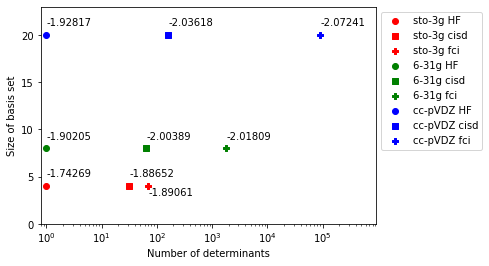

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = 'rgbk'
shapes = 'osP^'
max_x = max([res[k][0][0] for k in res])
max_y = max([res[k][0][1] for k in res])
for b, m in res:
    c = colors[basis_set_list.index(b)]
    s = shapes[['HF', 'cisd', 'fci'].index(m)]
    x, y = res[b,m][0]
    e = res[b,m][1]
    plt.scatter(x, y, c=c, marker=s, label=' '.join((b,m)))
    if (b, m) == ('sto-3g', 'fci') :
        plt.text(x, y-1, '%.5f'%e)
    else:
        plt.text(x, y+1, '%.5f'%e)
plt.legend(bbox_to_anchor=(1,1))
ax.set_xlim(0.8, max_x*10)
ax.set_ylim(0, max_y+3)
ax.set_xscale('log')
ax.set_xlabel('Number of determinants')
ax.set_ylabel('Size of basis set')